# Package Importing

In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint, normal
from keras.datasets import mnist
from keras.models import Model, load_model
from keras.layers import *
from keras import initializers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
import sys, os

In [2]:
from platform import python_version

print(python_version())

3.8.12


# Dataset and variable Initialization

In [3]:
(X_train, _), (_, _) = mnist.load_data()

#rescale data between -1 to 1

x_train = X_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis=3)
x_train.shape

(60000, 28, 28, 1)

In [4]:
im_row = x_train.shape[1]
im_col = x_train.shape[2]
im_channels= x_train.shape[3]
img_shape = (im_row, im_col, im_channels)
img_shape

(28, 28, 1)

In [5]:
latent_dim = 100

# Model Building

## Generator Model

In [6]:
def make_generator():
    in_dim = Input(shape=(latent_dim)) 
    gen = Dense(256)(in_dim)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Dense(512)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Dense(1024)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Dense(np.prod(img_shape), activation='tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_dim, out_layer, name='Generator')
    return model

In [7]:
generator = make_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                         

## Discriminator model

In [8]:
def make_discriminator():
    in_img = Input(shape=img_shape)
    x = Flatten()(in_img)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(in_img, out, name='Discriminator')
    return model

In [9]:
discriminator = make_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)               

## Building a generative model : Vanilla-GAN

In [10]:
#combined gan model
# making a generative model
def vanilla_gan(generator, discriminator):
    optimizer = Adam(0.0002, 0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # input made from latent_dim: as generator take noise as input and generate images
    inp_z = generator.input
    img = generator.output

    # Here we are making generative model so training on the discriminator is not necessary
    discriminator.trainable = False

    #discriminator take generated images and give validity to the output
    output_val = discriminator(img)
    
    #Here we combine both model and build our desire GAN architecture
    combine_model = Model(inp_z, output_val, name='Vanilla_GAN')
    combine_model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return combine_model


In [11]:
gan = vanilla_gan(generator, discriminator)
gan.summary()

Model: "Vanilla_GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                       

# Visualization function

In [12]:
def save_folder(name):
    directory = name
    parent_dir = os.getcwd()
    new_path = os.path.join(parent_dir,directory)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return new_path

def smaple_image(epoch, save_path):
    row, col = 5, 5
    noise =normal(0, 1, (row*col, latent_dim))
    generate_img = generator.predict(noise)
    
    #rescale image between 0-1
    gen_img = 0.5*generate_img + 0.5
    
    fig, axis = plt.subplots(row, col)
    count = 0
    for i in range(row):
        for j in range(col):
            axis[i,j].imshow(gen_img[count, :, :, 0], cmap = 'gray')
            axis[i,j].axis('off')
            count +=1
            
    fig.savefig(f'{save_path}\images{epoch}.png')
    plt.close()


# Training the model

In [13]:
def gan_train(epochs, batch_size = 128, sample_interval = 50):
    
    true_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))
    save_path = save_folder('Vanilla_GAN')

    epoch = 1
    while epoch <= epochs:
        
        # discriminator training
        idx = randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        noise = normal(0, 1, (batch_size, latent_dim)) #z

        #generate a new batch of image
        gen_img = generator.predict(noise)

        #discriminator training code
        
        ##get discriminator loss (real) using original images and true_labels as 1
        d_loss_r = discriminator.train_on_batch(imgs, true_label)
        
        ##get discriminator loss (fake) using generated images and fake_labels as 0
        d_loss_f = discriminator.train_on_batch(gen_img, fake_label)
        d_loss = 0.5 * np.add(d_loss_r, d_loss_f)

        # generator training code
        noise = normal(0, 1, (batch_size, latent_dim))
        # get gan_loss using noise and discriminator label as true or 1
        g_loss = gan.train_on_batch(noise, true_label) 

        #progress plotting
        print("%d > [Discriminator:-> loss: %f, accuracy: %.2f%%] [Generator:-> loss: %f]" % (epoch, d_loss[0], d_loss[1]*100, g_loss))
        if epoch % sample_interval == 0:
            #self.save_model()
            smaple_image(epoch, save_path)
        epoch += 1 

In [14]:
gan_train(epochs=10000, batch_size=32, sample_interval=200)

1/1 [==============================] - 1s 598ms/step
1 > [Discriminator:-> loss: 0.718420, accuracy: 39.06%] [Generator:-> loss: 0.555995]
1/1 [==============================] - 0s 13ms/step
2 > [Discriminator:-> loss: 0.412313, accuracy: 59.38%] [Generator:-> loss: 0.596315]
1/1 [==============================] - 0s 14ms/step
3 > [Discriminator:-> loss: 0.381966, accuracy: 60.94%] [Generator:-> loss: 0.626357]
1/1 [==============================] - 0s 13ms/step
4 > [Discriminator:-> loss: 0.360177, accuracy: 73.44%] [Generator:-> loss: 0.752938]
1/1 [==============================] - 0s 13ms/step
5 > [Discriminator:-> loss: 0.342116, accuracy: 75.00%] [Generator:-> loss: 0.840797]
1/1 [==============================] - 0s 12ms/step
6 > [Discriminator:-> loss: 0.303381, accuracy: 85.94%] [Generator:-> loss: 1.011894]
1/1 [==============================] - 0s 13ms/step
7 > [Discriminator:-> loss: 0.259194, accuracy: 98.44%] [Generator:-> loss: 1.140303]
1/1 [============================

In [19]:
import imageio.v2 as imageio
import glob
from IPython.display import Image
with imageio.get_writer('generator_evolution.gif', mode='I') as writer:
    filenames = glob.glob('Vanilla_GAN/images*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

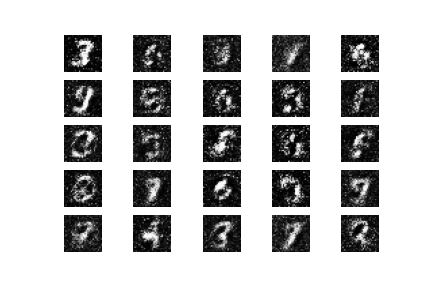

In [21]:
Image(open('generator_evolution.gif', 'rb').read())